# Portfolio Project: Biodiversity
## Initial loading of data

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
import math

# read data
species_info = pd.read_csv('species_info.csv')
observations = pd.read_csv('observations.csv')

species_info
print(species_info.head())
print(species_info.describe())
print(f'rows and columns: {species_info.shape}')
print('\n')
print(observations.head())
print(observations.describe())
print(f'rows and columns: {observations.shape}')

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  
              category       scientific_name        common_names  \
count             5824                  5824                5824   
unique               7                  5541                5504   
top     Vascular Plant  Hypochaeris radicata  Brachythecium Moss   
freq   

### Species:
contains info on observed species, including:
- category: what animal class they belong to
- scientific name: animal's scientific name
- common name: animal's common name
- conservation status: whether animal is endangered or not

5824 entries, 4 columns

### Observations:
contains info on species and their respective locations:
- scientific name: animal's scientific name
- park name: the place the animal was found in
- observations: amount of times found

23296 entries, 3 columns

Seems that conservation status of species_info is NaN (empty) unless stated otherwise, which implies that these species are not endangered.
Only 4 out of 191 species have a unique conservation status value, meaning that they maybe endangered or at risk.

meanwhile, observation list contains scientific name, park name, and number of times that particular species was found. both lists have scientific_name in common, so we can use that to connect them for analysis.

## initial exploration of data

### Species Info data:

In [11]:
print(f'number of unique species: {species_info.scientific_name.nunique()}')
print(f'number of species represented: {species_info.category.unique()}')
print(species_info.groupby('category').size())
print(f'# of unique conservation statuses: {species_info.conservation_status.unique()}')
print(f'na values: {species_info.conservation_status.isna().sum()}') #assuming na is normal
print(species_info.groupby('conservation_status').size())

number of unique species: 5541
number of species represented: ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']
category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64
# of unique conservation statuses: [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']
na values: 5633
conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64


Seems that there are 7 categories of plant and animal to look after, and 5 categories of conservation statuses to observe, assuming nan means normal.

### Observation list:

In [12]:
print(f'different parks: {observations.park_name.unique()}')
print(f'# of observations: {observations.observations.sum()}')

different parks: ['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']
# of observations: 3314739


we have 3,314,739 observations from 4 national parks. that's a lot.

### beginning analysis

In [13]:
#changing NA to something else to communicate no intervention of non endangered species
species_info.fillna('Safe', inplace= True) #change na to 'Safe'
species_info.groupby('conservation_status').size()

conservation_status
Endangered              16
In Recovery              4
Safe                  5633
Species of Concern     161
Threatened              10
dtype: int64

In [14]:
conservationCategory = species_info[species_info.conservation_status != 'Safe']\
                        .groupby(["conservation_status", 'category'])['scientific_name']\
                        .count().unstack()

conservationCategory

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


According to this table, What jumps out at me is the fact that there are 4 endangered bird species with 3 that are in recovery. There's 7 endangered mammals with one in recovery, which suggests that birds are making a comeback overall.

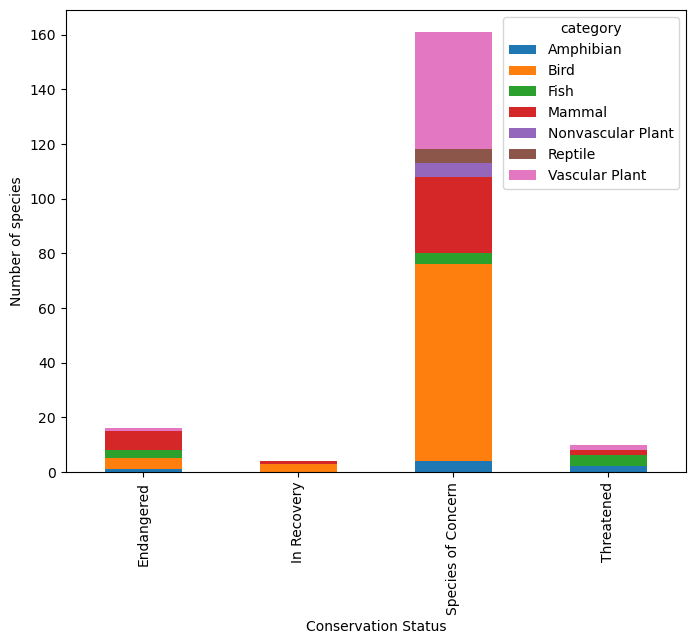

<Figure size 640x480 with 0 Axes>

In [15]:
conservationCategory.plot(kind = 'bar', figsize = (8,6), stacked=True)
plt.xlabel("Conservation Status")
plt.ylabel("Number of species")
plt.show()
plt.clf()

## #2: comparing species in and out of conservation
Now we'll answer what species are more likely to be endangered. first, we'll aggregate safe vs intervention species into a new column.

In [20]:
species_info['intervention'] = species_info['conservation_status'] != 'Safe' #safe = not touched, intervention = had to be rescued

safe_vs_intervene = species_info.groupby(['category', 'intervention']).scientific_name.nunique().reset_index()\
    .pivot(columns = 'intervention', index = 'category', values = 'scientific_name').reset_index()

safe_vs_intervene.columns = ['category','no intervention','intervention']
safe_vs_intervene

,category,no intervention,intervention
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


In [22]:
# must convert to percentages for increased clarity
safe_vs_intervene['intervention percentage'] = safe_vs_intervene.intervention / (safe_vs_intervene.intervention + safe_vs_intervene['no intervention']) * 100
safe_vs_intervene

,category,no intervention,intervention,intervention percentage
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305
